In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import numpy as np
import pandas as pd
import openpyxl
import nltk
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Bidirectional, Input, Embedding, LSTM, Dense, Flatten
from tensorflow.keras.models import Model

# Load Datasets

In [5]:
from datasets import load_dataset
df_indoqa_train = load_dataset("jakartaresearch/indoqa", split='train')
df_indoqa_train = df_indoqa_train.to_pandas()
df_indoqa_train.head()

,id,context,question,answer,category,span_start,span_end
0,629HsNl5Qf3THUq_CbmFrSx28,"Para pemuda pejuang, termasuk Chaerul Saleh, S...","Dengan siapa Chaerul Saleh, Sukarni, Wikana, d...",Ibrahim gelar Datuk Tan Malaka,SPAN,128,158
1,2648F832Z8D-thJnrxy_ZoZ11111,Malaysia terdiri atas dua kawasan utama yang t...,Kapan angin muson timur laut berhembus?,Oktober hingga Februari,SPAN,430,453
2,2561YDPNx6Nm5o6T0F-PGw-u2466,"Pada 16 Februari 1830, Diponegoro setuju untuk...",Siapa yang diutus oleh Jendral De Kock yang be...,Kolonel Jan Baptist Clereens,SPAN,93,121
3,1431C0_ORK0ta8pDX6H-1VOp596,Kerajaan Buddhis Ligor segera kembali mengenda...,Apa yang chandrabanu lakukan setelah menguasai...,menggunakan tempat ini sebagai basis untuk men...,SPAN,82,144
4,1234WIzl7ElikCCPk4gA-7ua3057,Sikap terhadap perbudakan juga berubah; semua ...,Kapan seluruh negara bagian Utara menghapuskan...,antara tahun 1780 dan 1804,SPAN,248,274


In [32]:
#LOAD VAL DATA
df_indoqa_val = load_dataset("jakartaresearch/indoqa", split='validation')
df_indoqa_val = df_indoqa_val.to_pandas()
df_indoqa_val.head()

,id,context,question,answer,category,span_start,span_end
0,626qIhrr3hXbXzErP6nHf4L36,Soekarno dan Hatta selaku pimpinan PPKI serta ...,Siapa pemimpin PPKI?,Soekarno dan Hatta,SPAN,0,18
1,1425958dFD204WSt04379,"Pada 24 September 2018, BTS menghadiri Pertemu...",Kapan Pertemuan Sidang Umum 2022 dilaksanakan?,None,UNANSWERABLE,-1,-1
2,2401lBblJQgObznj6i-AaGXg3644,Pada masa pemerintahan khalifah ke-3 yakni Uts...,Keputusan apakah yang diambil Utsman untuk men...,membuat sebuah mushaf standar (menyalin mushaf...,SPAN,303,424
3,1459Gtt57D0AV39kKJE2bz4b2094,Taman Lapangan Banteng merupakan taman lain ya...,Monumen apa yang ada di Taman Lapangan Banteng?,Monumen Pembebasan Irian Barat,SPAN,125,155
4,2444WhZ9ERauvkt18jQSbdFq1906,Beberapa alasan mengapa orang mengalami kesuli...,Apakah definisi budaya ?,suatu perangkat rumit nilai-nilai yang dipolar...,SPAN,147,273


In [33]:
#COMBINE DATASET
df_indoqa = pd.concat([df_indoqa_train, df_indoqa_val], ignore_index=True)

In [8]:
#REMOVE UNANSWERABLE QUESTIONS
df_indoqa = df_indoqa.drop(df_indoqa[df_indoqa['category']=='UNANSWERABLE'].index)

In [9]:
#CHOOSE DESIREABLE COLUMNS
column = ['question', 'answer','id']
df_indoqa = df_indoqa[column]
df_indoqa.head()

,question,answer,id
0,"Dengan siapa Chaerul Saleh, Sukarni, Wikana, d...",Ibrahim gelar Datuk Tan Malaka,629HsNl5Qf3THUq_CbmFrSx28
1,Kapan angin muson timur laut berhembus?,Oktober hingga Februari,2648F832Z8D-thJnrxy_ZoZ11111
2,Siapa yang diutus oleh Jendral De Kock yang be...,Kolonel Jan Baptist Clereens,2561YDPNx6Nm5o6T0F-PGw-u2466
3,Apa yang chandrabanu lakukan setelah menguasai...,menggunakan tempat ini sebagai basis untuk men...,1431C0_ORK0ta8pDX6H-1VOp596
4,Kapan seluruh negara bagian Utara menghapuskan...,antara tahun 1780 dan 1804,1234WIzl7ElikCCPk4gA-7ua3057


# Preprocessing

In [10]:
#Dataset Information
df_indoqa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4333 entries, 0 to 4412
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  4333 non-null   object
 1   answer    4333 non-null   object
 2   id        4333 non-null   object
dtypes: object(3)
memory usage: 135.4+ KB


In [11]:
#Missing Values Checking
df_indoqa.isna().sum()

question    0
answer      0
id          0
dtype: int64

In [12]:
#Remove punctuation and capital
df_indoqa["question"] = df_indoqa["question"].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])

df_indoqa["question"] = df_indoqa["question"].apply(lambda wrd: ''.join(wrd))


In [13]:
tag_to_answer = dict(zip(df_indoqa['id'], df_indoqa['answer']))

In [14]:
#Tokenizing
tokenizer = Tokenizer(num_words = 11305)
tokenizer.fit_on_texts(df_indoqa["question"])
train = tokenizer.texts_to_sequences(df_indoqa["question"])

In [15]:
x_train = pad_sequences(train)
x_train

array([[   0,    0,    0, ...,  382, 1282, 2652],
       [   0,    0,    0, ...,  185,  383, 2653],
       [   0,    0,    0, ...,    1,  563,   78],
       ...,
       [   0,    0,    0, ...,  599, 5402, 1155],
       [   0,    0,    0, ...,  234,   18,   80],
       [   0,    0,    0, ...,   27,  182,  825]], dtype=int32)

In [16]:
le = LabelEncoder()
y_train = le.fit_transform(df_indoqa["id"])
y_train

array([3554, 2799, 2635, ..., 4319, 2225, 4332])

In [17]:
input_shape = x_train.shape[1]
print(input_shape)

20


In [18]:
unique_words = len(tokenizer.word_index)
output_length = le.classes_.shape[0]
print(unique_words)
print(output_length)

5406
4333


# Model Architecture

In [19]:
import tensorflow as tf
model = tf.keras.Sequential()
model.add(Input(shape=(input_shape,)))
model.add(Embedding(unique_words+1, 20, input_length= (input_shape,)))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Flatten())
model.add(Dense(units= 64, activation='relu'))
model.add(Dense(units= 32, activation='relu'))
model.add(Dense(units= output_length, activation='softmax'))

model.compile(loss = "sparse_categorical_crossentropy", optimizer ='adam', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [20]:
from tensorflow.keras.optimizers import Adam
learning_rate = 0.001  

optimizer = Adam(learning_rate=learning_rate)
model.compile(loss = "sparse_categorical_crossentropy", optimizer ='adam', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 20, 20)         │       108,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 20, 128)        │        43,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       163,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4333)           │       142,989 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 460,633 (1.76 MB)

 Trainable params: 460,633 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

# Train

In [22]:
history = model.fit(x_train, y_train, epochs=200)

Epoch 1/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.0000e+00 - loss: 8.3829
Epoch 2/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0000e+00 - loss: 8.3768
Epoch 3/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0000e+00 - loss: 8.3772
Epoch 4/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0000e+00 - loss: 8.3769
Epoch 5/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0012 - loss: 8.3203
Epoch 6/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 4.2327e-04 - loss: 8.1747
Epoch 7/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0000e+00 - loss: 7.9920
Epoch 8/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 8.5570e-05 - loss: 7.7932
Epoch 9/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 7.7186e-04 - loss: 7.5428
Epoch 10/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0022 - loss: 7.2793
Epoch 11/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0054 - loss: 7.1078
Epoch 12/

In [26]:
model.save("aicademy_lstm.h5")

# Visualization

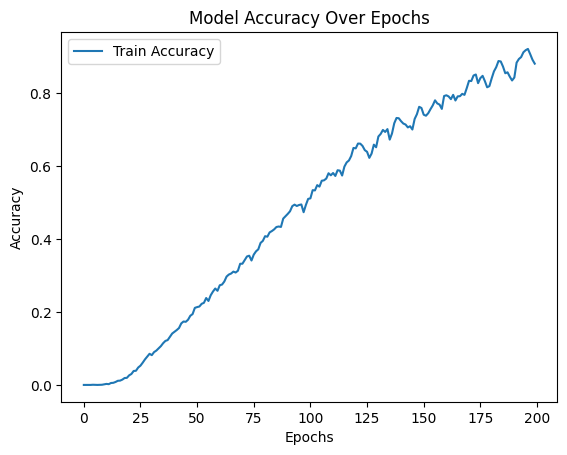

In [29]:
import matplotlib.pyplot as plt
train_accuracy = history.history['accuracy']
plt.plot(train_accuracy, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()

plt.show()

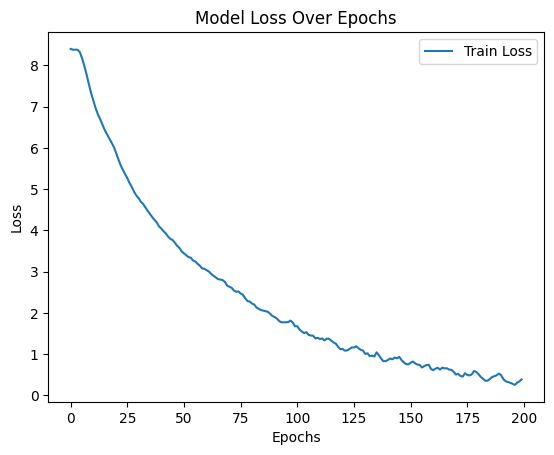

In [30]:
train_loss = history.history['loss']
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()

plt.show()

# ChatBot Demo

In [28]:
while True:
    textList = []
    user_input = input("You: ")
    prediction_input = []

    for letter in user_input:
        if letter not in string.punctuation:
            prediction_input.append(letter.lower())

    prediction_input = ''.join(prediction_input)
    textList.append(prediction_input)
    
    prediction_input = tokenizer.texts_to_sequences(textList)
    prediction_input = np.array(prediction_input).reshape(-1)
    prediction_input = pad_sequences([prediction_input], input_shape)
    
    output = model.predict(prediction_input)
    output = output.argmax()
    
    response_tag = le.inverse_transform([output])[0]
    bot_response = tag_to_answer.get(response_tag, "Sorry, I don't understand that question.")

    print("You: ", user_input)
    print("Bot: ", bot_response)
    
    if user_input == 'goodbye':
        bot_response == 'Good Bye! Thank you for using this feature!'
        print("Goodbye!")
        
        break

You:  Siapa pemimpin ppki?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
You:  Siapa pemimpin ppki?
Bot:  Soekarno dan Hatta


You:  siapa pemimpin ppki?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
You:  siapa pemimpin ppki?
Bot:  Soekarno dan Hatta


You:  Kapan angin muson timur laut berhembus?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
You:  Kapan angin muson timur laut berhembus?
Bot:  Oktober hingga Februari


You:  goodbye


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
You:  goodbye
Bot:  blusukan hanya menghabiskan waktu dan energi
Goodbye!
